In [1]:
import tweepy
import json
import pickle
import os
import pandas as pd
import networkx as nx

from code import utils, pipelines
from code.graphs import PoliticalMultiGraph, PoliticalGraph
from code.representative import Representative

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data/politicians.csv', index_col='Screen_name')
data.head()

Name    State Party           Twitter
Screen_name                                                            
Rep. Terri A. Sewell   Terri A. Sewell  Alabama     D   @RepTerriSewell
Rep. Tom O'Halleran     Tom O’Halleran  Arizona     D     @RepOHalleran
Rep. Ann Kirkpatrick   Ann Kirkpatrick  Arizona     D   @RepKirkpatrick
Raul M. Grijalva      Raul M. Grijalva  Arizona     D  @RepRaulGrijalva
Ruben Gallego            Ruben Gallego  Arizona     D  @RepRubenGallego

In [3]:
data_groups = data.groupby('Party')

republicans = data_groups.get_group('R')
democrats = data_groups.get_group('D')

In [4]:
republican_representatives = []

for index, row in republicans.iterrows():
    republican_representatives.append(Representative(*row))

In [5]:
with open('republican_likes.json', 'rb') as f:
    republican_likes = json.load(f)
    
len(republican_likes)

196

In [6]:
for rep in republican_representatives:
    rep.parse_user('data/republican_representatives/')
    rep.update_likes(republican_likes[rep.path_name])

In [7]:
for rep in republican_representatives:
    if not rep.is_parsed:
        print(rep.screen_name)

RepRobWoodall


In [5]:
democrat_representatives = []

for index, row in democrats.iterrows():
    democrat_representatives.append(Representative(*row))
    
with open('democrat_likes.json', 'rb') as f:
    democrat_likes = json.load(f)
    
len(democrat_likes)

227

In [6]:
for rep in democrat_representatives:
    rep.parse_user('data/democrat_representatives/')
    rep.update_likes(democrat_likes[rep.path_name])
    
for rep in democrat_representatives:
    if not rep.is_parsed:
        print(rep.screen_name)

In [8]:
republicans_likes_network = PoliticalGraph(republican_representatives)
republicans_retweets_network = PoliticalGraph(republican_representatives)
republicans_mentions_network = PoliticalGraph(republican_representatives)

republicans_likes_network.add_interactions('likes', color='green')
republicans_retweets_network.add_interactions('retweets', color='red')
republicans_mentions_network.add_interactions('mentions', color='blue')

republicans_likes_network.delete_isolated_nodes()
republicans_retweets_network.delete_isolated_nodes()
republicans_mentions_network.delete_isolated_nodes()

In [7]:
democrats_likes_network = PoliticalGraph(democrat_representatives)
democrats_retweets_network = PoliticalGraph(democrat_representatives)
democrats_mentions_network = PoliticalGraph(democrat_representatives)

democrats_likes_network.add_interactions('likes', color='green')
democrats_retweets_network.add_interactions('retweets', color='red')
democrats_mentions_network.add_interactions('mentions', color='blue')

democrats_likes_network.delete_isolated_nodes()
democrats_retweets_network.delete_isolated_nodes()
democrats_mentions_network.delete_isolated_nodes()

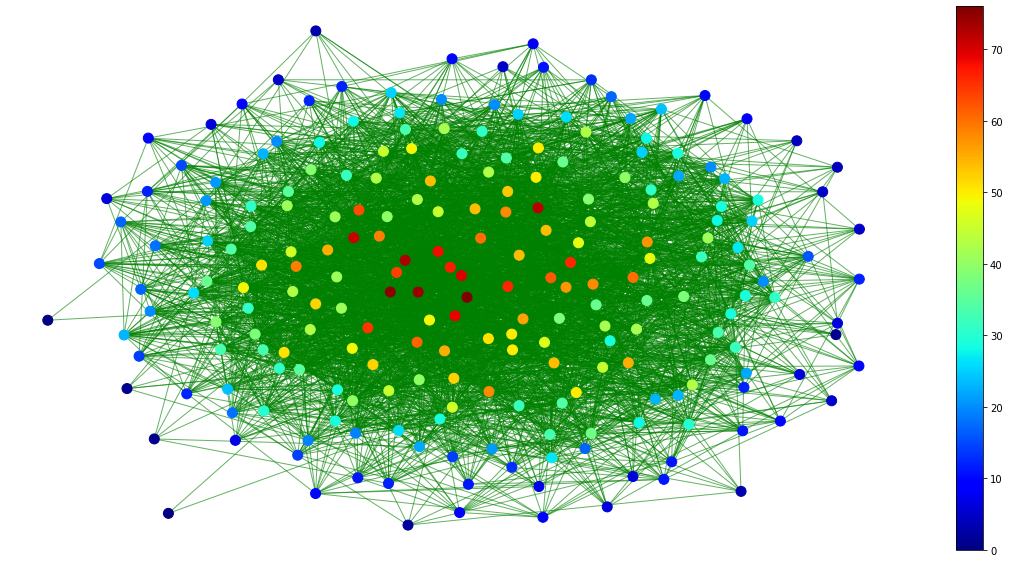

In [8]:
democrats_likes_network.draw_graph(layout=nx.kamada_kawai_layout, edge_attrs={'alpha':0.6}, node_attrs={'node_size': 100}, save_fig=True, save_fig_path='small_republican_graph.png')

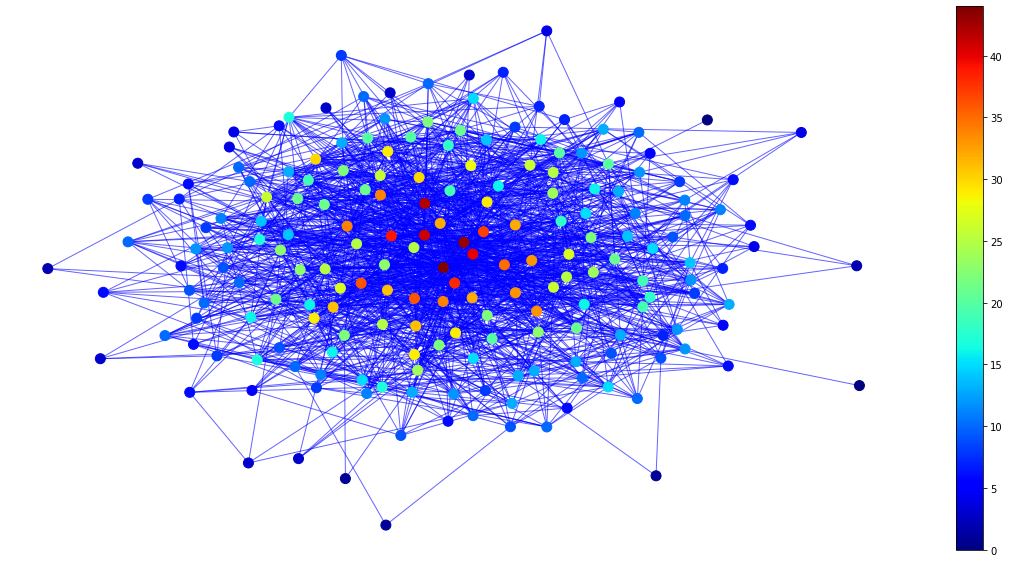

In [10]:
republicans_mentions_network.draw_graph(layout=nx.kamada_kawai_layout, edge_attrs={'alpha':0.6}, node_attrs={'node_size': 100}, save_fig=True, save_fig_path='small_republican_graph.png')

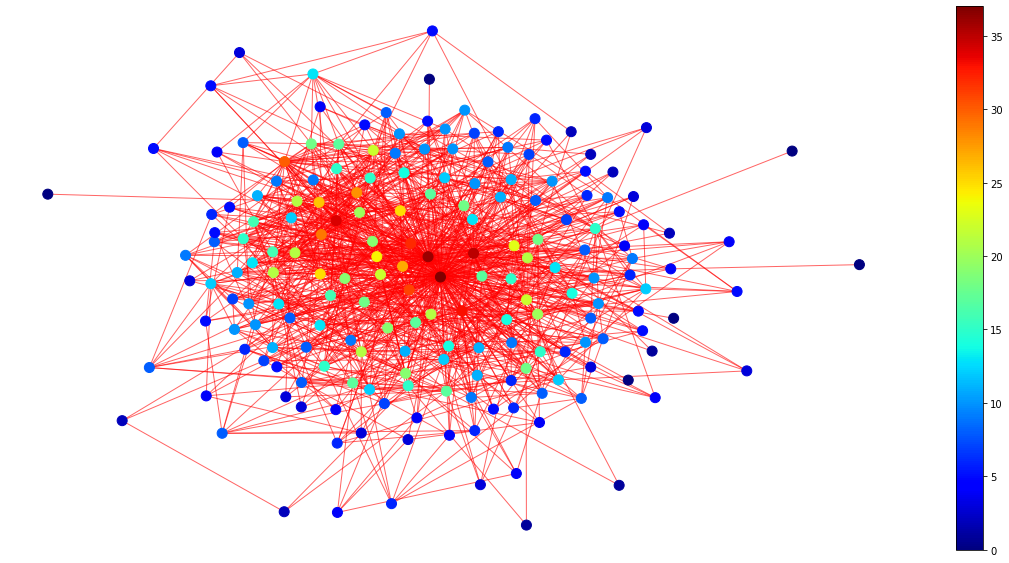

In [11]:
republicans_retweets_network.draw_graph(layout=nx.kamada_kawai_layout, edge_attrs={'alpha':0.6}, node_attrs={'node_size': 100}, save_fig=True, save_fig_path='small_republican_graph.png')

In [18]:
sorted(list(nx.betweenness_centrality(republicans_likes_network.graph).items()), key=lambda item: item[1], reverse=True)[:10]

[('SteveScalise', 0.17427306886069224),
 ('GOPLeader', 0.13079691577060243),
 ('RepBradWenstrup', 0.03446182961166803),
 ('RepDonBacon', 0.0270997171433986),
 ('RepKevinBrady', 0.025999640238494073),
 ('cathymcmorris', 0.01853432989839912),
 ('HerreraBeutler', 0.0172671336148529),
 ('RepRichHudson', 0.0171167617537721),
 ('RepLeeZeldin', 0.01627539270508758),
 ('RepAndyBiggsAZ', 0.015439490083150924)]

In [19]:
sorted(list(nx.betweenness_centrality(republicans_retweets_network.graph).items()), key=lambda item: item[1], reverse=True)[:10]

[('GOPLeader', 0.392479831423467),
 ('SteveScalise', 0.20503399239473435),
 ('RepBradWenstrup', 0.05102895385812507),
 ('Jim_Jordan', 0.020974121385902378),
 ('DesJarlaisTN04', 0.017569784523262532),
 ('RepKevinBrady', 0.016518546474034005),
 ('RepMikeJohnson', 0.014723784267919628),
 ('RepMichaelWaltz', 0.014021822580282695),
 ('RepDonBacon', 0.013641253508312613),
 ('RepMcCaul', 0.013358553324933388)]

In [20]:
sorted(list(nx.betweenness_centrality(republicans_mentions_network.graph).items()), key=lambda item: item[1], reverse=True)[:10]

[('GOPLeader', 0.1857252008104624),
 ('SteveScalise', 0.14591955242999508),
 ('RepKenBuck', 0.04404894477887037),
 ('RepTimBurchett', 0.03024370948911031),
 ('HerreraBeutler', 0.020700160151405387),
 ('TXRandy14', 0.020202717826747135),
 ('RepJackBergman', 0.020145627062186894),
 ('RepLizCheney', 0.01848783985183823),
 ('RepKevinBrady', 0.01704647908515626),
 ('RepRutherfordFL', 0.016723749787201588)]

In [10]:
def to_gephi(graph, path):
    edges = list(graph.edges(data=True))
    nodes = list(graph.nodes(data=True))
    
    formated_edges = [{'Source': edge[0], 'Target': edge[1], 'Weight': sum([edge[2]['likes'], edge[2]['retweets'], edge[2]['mentions']])} for edge in edges]
    formated_nodes = [{'Id': rep[0], 'State': rep[1]['state'], 'Name':rep[1]['name'], 'Party':rep[1]['party']} for rep in nodes]
    
    df_edges = pd.DataFrame(formated_edges)
    df_nodes = pd.DataFrame(formated_nodes)
    
    df_edges.to_csv(path+'edges.csv', index=False)
    df_nodes.to_csv(path+'nodes.csv', index=False)

In [49]:
to_gephi(republicans_likes_network.graph, 'data/interactions/republican_likes/')

In [50]:
to_gephi(republicans_mentions_network.graph, 'data/interactions/republican_mentions/')

In [51]:
to_gephi(republicans_retweets_network.graph, 'data/interactions/republican_retweets/')

In [11]:
to_gephi(democrats_mentions_network.graph, 'data/interactions/democrat_mentions/')

In [12]:
to_gephi(democrats_retweets_network.graph, 'data/interactions/democrat_retweets/')

In [13]:
to_gephi(democrats_likes_network.graph, 'data/interactions/democrat_likes/')